# Project description


**Task statement**
- Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.
- The model should predict the amount of gold recovered from gold ore. 
- You have the data on extraction and purification.




# IMPORT LIBRARIES


In [1]:
#Import all libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns#visualization
sns.set(style="ticks", color_codes=True)

import itertools

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import sys
print (sys.version)

#define most used variables
RANDOM_STATE=12345
PRINTING_SEPARATOR = '*' * 100
EPSILON = 1e-10
TARGET1 = 'rougher.output.recovery'
TARGET2 = 'final.output.recovery'
TARGETS=[TARGET1,TARGET2]

3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:57:50) 
[GCC 7.5.0]


# DEFINE and SET GLOBAL VARIABLES

In [2]:
#MAKE THE LISTS FOR DATA PREPROCESSING, ANALYSIS and CLEANUP
stage = ['rougher.output.','primary_cleaner.output.','final.output.']
heart = ["concentrate"]
metals = ['_au','_ag','_pb']

list_au = [stage,heart,['_au']]
list_ag = [stage,heart,['_ag']]
list_pb = [stage,heart,['_pb']]
list_sol = [stage,heart,['_sol']]

feed_au =['rougher.input.feed_au']
feed_ag =['rougher.input.feed_ag']
feed_pb = ['rougher.input.feed_pb']
feed_sol = ['rougher.input.feed_sol']

lists = [stage,heart,metals] # Or more
CONCENTRATE_LIST  = ["".join(i) for i in itertools.product(*lists)]
ALL_LIST = CONCENTRATE_LIST + feed_au + feed_ag + feed_pb + feed_sol
CONCENTRATE_AU_LIST = ["".join(i) for i in itertools.product(*list_au)]
CONCENTRATE_AG_LIST = ["".join(i) for i in itertools.product(*list_ag)]
CONCENTRATE_PB_LIST = ["".join(i) for i in itertools.product(*list_pb)]
CONCENTRATE_SOL_LIST = ["".join(i) for i in itertools.product(*list_sol)]

ALL_AU_LIST = CONCENTRATE_AU_LIST + feed_au
ALL_AG_LIST = CONCENTRATE_AG_LIST + feed_ag
ALL_PB_LIST = CONCENTRATE_PB_LIST + feed_pb
ALL_SOL_LIST = CONCENTRATE_SOL_LIST + feed_sol

listAllMetals = ['AllAu','AllAg','AllPb','AllSol']

print(CONCENTRATE_LIST)
print(CONCENTRATE_AU_LIST)
print(ALL_AU_LIST)

['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']
['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au', 'rougher.input.feed_au']


# GLOBAL FUNCTIONS

In [3]:
#I DEFINED A MACRO FOR "PRINT" and "DISPLAY" FUNCTION using DEBUG FLAG
#If DEBUG=0, the PRINT(), DISPLAY() function will print nothing
#If DEBUG=1, the PRINT(), DISPLAY() function will work like the standard functions

def printNothing(*args):
  pass

DEBUG=0  
if (DEBUG):
  print('DEBUG ON')
  PRINT = print
  DISPLAY = display
else:
  print('DEBUG OFF')
  PRINT = printNothing
  DISPLAY = printNothing

DEBUG OFF


In [4]:
#Test of DEBUG FLAG
PRINT('test')

In [5]:
#Use it to print separator between the printing information
def PRINT_SEPARATOR():
  print(PRINTING_SEPARATOR)
  print()

In [6]:
#Distribution Plot drawing Function
#Input is dataframe columns, labels and kde plot
#Output is a Distribution plot (kde or standard)
def DRAW_DISTPLOT(dataVals,labelVals,kdeVal):
     f = plt.figure(figsize=(10,6))
     for i in range(len(dataVals)):
        sns.distplot(dataVals[i],kde_kws={"lw": 3},label=labelVals[i],kde=kdeVal)
     plt.legend()
     plt.show()

In [7]:
#Draw a kde plot as per the parameters
def concentrationMetals(metalName,vals,df):
    PRINT_SEPARATOR()
    print("CONCENTRATION OF: ", metalName)

    df[vals].plot.kde(title="Concentrations for:" + metalName,figsize=(10,6))
    plt.show()
    display(df[vals].describe())

# 1.  PREPARE THE DATA

**Data FILES**
The data is stored in three files:
-  gold_recovery_train.csv — training dataset download
-  gold_recovery_test.csv — test dataset download
-  gold_recovery_full.csv — source dataset download

**STEPS:**

- Prepare the data;
- Perform data analysis

**CONSTRAINTS**
- Data is indexed with the date and time of acquisition (date feature).
- Parameters that are next to each other in terms of time are often similar.
- Some parameters are not available because they were measured and/or calculated much later. 
- That's why, some of the features that are present in the training set may be absent from the test set. 
- The test set also doesn't contain targets.
- The source dataset contains the training and test sets with all the features.
- You have the raw data that was only downloaded from the warehouse.
- Before building the model, check the correctness of the data. 



# DATA DESCRIPTION
**Technological process**
-    Rougher feed — raw material
-    Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
  -      Xanthate — promoter or flotation activator;
  -      Sulphate — sodium sulphide for this particular process;
  -      Depressant — sodium silicate.
-    Rougher process — flotation
-    Rougher tails — product residues
-    Float banks — flotation unit
-    Cleaner process — purification
-    Rougher Au — rougher gold concentrate
-    Final Au — final gold concentrate

**Parameters of stages**
-    air amount — volume of air
-    fluid levels
-    feed size — feed particle size
-    feed rate

**Feature naming**
-  Here's how you name the features:
-  [stage].[parameter_type].[parameter_name]
-  Example: rougher.input.feed_ag

**Possible values for [stage]:**
 -    rougher — flotation
 -    primary_cleaner — primary purification
 -    secondary_cleaner — secondary purification
 -    final — final characteristics

**Possible values for [parameter_type]:**
 -    input — raw material parameters
 -    output — product parameters
 -    state — parameters characterizing the current state of the stage
 -    calculation — calculation characteristics






# 1.1 OPEN THE FILES AND LOOK INTO THE DATA

In [8]:
#Import the file and create the dataset
path = '/datasets'

#Create dataframes to store the source data
df_train = pd.read_csv(path+'/gold_recovery_train.csv',parse_dates=['date'])   #training dataset download
df_test = pd.read_csv(path+'/gold_recovery_test.csv',parse_dates=['date'])    #test dataset download
df_source = pd.read_csv(path+'/gold_recovery_full.csv',parse_dates=['date'])    #source dataset download

#Make lists of dataframes for processing of dataframes
#df_stt is source, training, test datasets
df_stt = [df_source,df_train,df_test]
df_stt_names=['df_source','df_train','df_test']

#train, test
df_all=[df_train,df_test]  
df_all_names=['df_train','df_test']

In [9]:
def display_information(df):
    print('Head:')
    print()
    display(df.head())
    print ('-'*100)
    print('Info:')
    print()
    display(df.info())
    print ('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print ('-'*100)
    print('Columns with nulls:')
    print(get_percent_of_na_df(df,4))
    print ('-'*100)
    print('Shape:')
    print(df.shape)
    print ('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.'.format(df.duplicated().sum()) + "\033[0m")
    
def get_percent_of_na_df(df,num):
    print("in percent of na")
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    print(df_nulls)
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    return df_nulls

In [10]:
for i in range(3):
    print("Dataset Name: ",df_stt_names[i])
    display_information(df_stt[i])
    PRINT_SEPARATOR()

Dataset Name:  df_source
Head:



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null datetime64[ns]
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primar

None

----------------------------------------------------------------------------------------------------
Describe:



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


----------------------------------------------------------------------------------------------------
Columns with nulls:
in percent of na
                                            Missing Values
date                                                     0
final.output.concentrate_ag                             89
final.output.concentrate_pb                             87
final.output.concentrate_sol                           385
final.output.concentrate_au                             86
...                                                    ...
secondary_cleaner.state.floatbank5_a_level             101
secondary_cleaner.state.floatbank5_b_air               101
secondary_cleaner.state.floatbank5_b_level             100
secondary_cleaner.state.floatbank6_a_air               119
secondary_cleaner.state.floatbank6_a_level             101

[87 rows x 1 columns]
                                            Missing Values  Percent of Nulls
date                                                  

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null datetime64[ns]
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primar

None

----------------------------------------------------------------------------------------------------
Describe:



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


----------------------------------------------------------------------------------------------------
Columns with nulls:
in percent of na
                                            Missing Values
date                                                     0
final.output.concentrate_ag                             72
final.output.concentrate_pb                             72
final.output.concentrate_sol                           370
final.output.concentrate_au                             71
...                                                    ...
secondary_cleaner.state.floatbank5_a_level              85
secondary_cleaner.state.floatbank5_b_air                85
secondary_cleaner.state.floatbank5_b_level              84
secondary_cleaner.state.floatbank6_a_air               103
secondary_cleaner.state.floatbank6_a_level              85

[87 rows x 1 columns]
                                            Missing Values  Percent of Nulls
date                                                  

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatban

None

----------------------------------------------------------------------------------------------------
Describe:



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


----------------------------------------------------------------------------------------------------
Columns with nulls:
in percent of na
                                            Missing Values
date                                                     0
primary_cleaner.input.sulfate                          302
primary_cleaner.input.depressant                       284
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         166
primary_cleaner.state.floatbank8_a_air                  16
primary_cleaner.state.floatbank8_a_level                16
primary_cleaner.state.floatbank8_b_air                  16
primary_cleaner.state.floatbank8_b_level                16
primary_cleaner.state.floatbank8_c_air                  16
primary_cleaner.state.floatbank8_c_level                16
primary_cleaner.state.floatbank8_d_air                  16
primary_cleaner.state.floatbank8_d_level                16
rougher.input.feed_ag               

# 1.3 ANALYZE THE FEATURES NOT AVAILABLE IN THE TEST SET. 
- What are these parameters?
- What is their type?

In [11]:
def findMissingCols():
    columnsSource = df_source.columns
    columnsTest = df_test.columns
    missingCols=[]
    
    print('Source: ', columnsSource.size,df_source.shape, 'Test:',columnsTest.size,df_test.shape )

    # prints the missing columns in df_test  
    missingColsCount = columnsSource.size - columnsTest.size
    display("Total number of missing columns in Test dataset:", missingColsCount)
    if (missingColsCount>0):
        missingCols = columnsSource.difference(columnsTest)
        DISPLAY(df_source[missingCols].info())
    return missingCols,missingColsCount

missingCols,missingColsSize = findMissingCols()
PRINT('Check if all df_test in df_source before processing:',df_test.set_index('date').isin(df_source.set_index('date')).sum())
df_test=df_test.set_index('date').merge(df_source.set_index('date')[missingCols],how='inner',on='date').reset_index(level='date')
df_all[1] = df_test  #Because merge makes a copy, so saving in the list again 
PRINT_SEPARATOR()
print (df_test.shape,'\n')
print('\nCheck if all df_test in df_source after getting data from source:',df_test.set_index('date').isin(df_source.set_index('date')).sum())

print('\nNew column count:',df_test.columns.size,df_train.columns.size)

Source:  87 (22716, 87) Test: 53 (5856, 53)


'Total number of missing columns in Test dataset:'

34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 34 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_au                                  22635 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
primary_cleaner.output.concentrate_ag                 22618 non-null float64
primary_cleaner.output.concentrate_au                 22618 non-null float64
primary_cleaner.output.concentrate_pb       

# 1.3 CONCLUSION
- There are 33 missing columns in the Test Dataset. This is a huge number.
- All of these columns are float.
- They may be missing because at the time of separating the source dataset into  test dataset and train dataset, this information wasn't available.
- At a later stage, the source dataset got more columns (information) for the exising records. The Source dataset was updated but Test dataset was missed for the update.
- The missing columns are 
 - output_concentrates at all stages of all metals. 
 - ratios of the material used in cleaning and flotation processes
- I brought all the missing columns in the test dataset from the training dataset. Now we have a full test dataset.



# 2. ANALYZE THE DATA
- Handling Missing Data
- Handling Erroneous Data

In [12]:
#Convert date to float format with number of days from the minimum date in the dataset
# Replace Nans using ffill
i=0
for dftmp in df_all:
  dftmp['date'] = (dftmp['date'] - dftmp['date'].min())  / np.timedelta64(1,'D')
  dftmp.fillna(method='ffill',inplace=True)
  rows_with_inf = dftmp[dftmp.apply(lambda x: any(np.isinf(x)), axis=1)]
  print('NAN VALUES')
  PRINT_SEPARATOR()
  display(df_all_names[i])
  display(rows_with_inf)
  i+=1

NAN VALUES
****************************************************************************************************



'df_train'

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


NAN VALUES
****************************************************************************************************



'df_test'

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_au,rougher.output.tail_pb,rougher.output.tail_sol,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol


# CONCLUSION:
- All dataframes: No null elements

# 2.3 TOTAL CONCENTRATION OF ALL SUBSTANCES AT VARIOUS STAGES
- Look at 3 stages rougher.input.feed_…, features_rough_concentrate_…, features_final_concentrate_…. 
- Sum up these concentrations for au/ag/pb/sol element and plot it on histograms. 
- On each such histogram, find abnormal values and remove them.

****************************************************************************************************

TRAINING SAMPLE: TOTAL CONCENTRATION OF ALL SUBSTANCES AT VARIOUS STAGES
****************************************************************************************************

CONCENTRATION OF:  Au


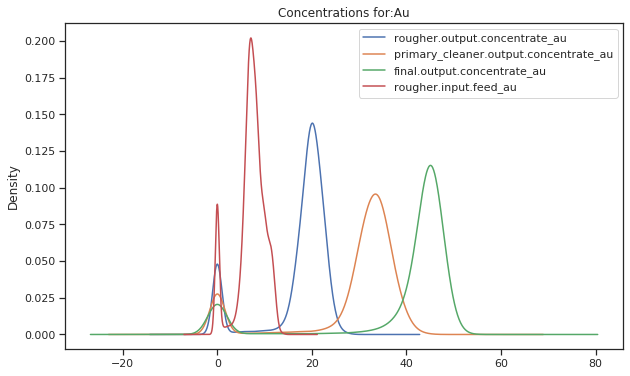

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au,rougher.input.feed_au
count,16860.000000,16860.000000,16860.000000,16860.000000
mean,17.337662,29.041786,39.321631,7.144279
std,6.985496,11.124170,14.095421,3.026064
min,0.000000,0.000000,0.000000,0.000000
25%,17.400564,29.581985,42.003201,6.186757
50%,19.631078,32.630490,44.484966,7.429346
75%,21.219480,35.004503,45.969495,8.954083
max,28.522811,45.933934,53.611374,14.093363


****************************************************************************************************

CONCENTRATION OF:  Ag


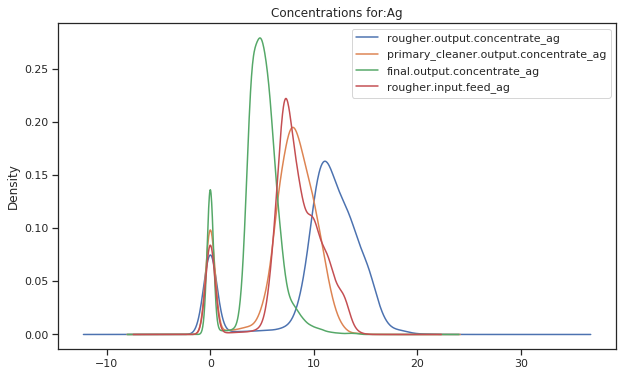

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.input.feed_ag
count,16860.000000,16860.000000,16860.000000,16860.000000
mean,10.541930,7.390585,4.699066,7.803825
std,4.486629,3.135757,2.111997,3.167145
min,0.000000,0.000000,0.000000,0.000000
25%,9.953223,6.592263,3.958988,6.880442
50%,11.444529,7.985558,4.860663,7.929318
75%,13.267408,9.393336,5.816487,9.816174
max,24.480271,16.081632,16.001945,14.869652


****************************************************************************************************

CONCENTRATION OF:  Pb


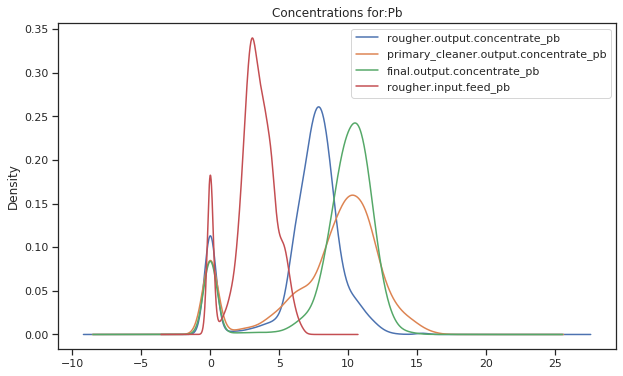

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,rougher.input.feed_pb
count,16860.000000,16860.000000,16860.000000,16860.000000
mean,6.861249,8.493673,9.080638,3.188803
std,2.959401,3.909885,3.428085,1.495402
min,0.000000,0.000000,0.000000,0.000000
25%,6.331015,6.918728,8.803975,2.516519
50%,7.578584,9.556796,10.059206,3.278689
75%,8.501206,11.100156,11.052001,4.169530
max,18.394042,17.081278,17.031899,7.142594


****************************************************************************************************

CONCENTRATION OF:  SOL


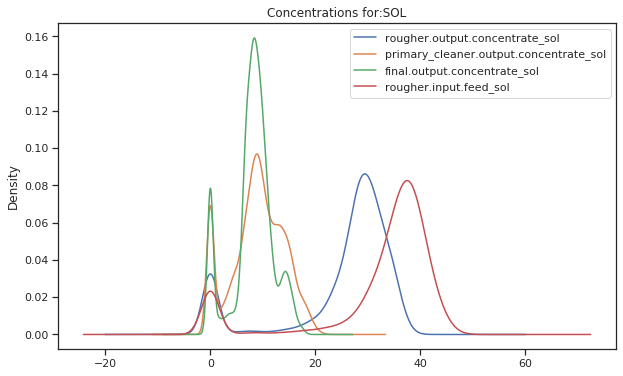

,rougher.output.concentrate_sol,primary_cleaner.output.concentrate_sol,final.output.concentrate_sol,rougher.input.feed_sol
count,16860.000000,16860.000000,16860.000000,16860.000000
mean,25.220949,8.956931,8.166207,32.306590
std,10.556731,4.991707,3.907771,11.992704
min,0.000000,0.000000,0.000000,0.000000
25%,24.569387,6.145816,6.822682,31.918512
50%,28.758204,9.148506,8.493195,36.278220
75%,31.522026,12.630597,10.239610,38.995296
max,40.089993,22.280845,18.124851,48.363177


****************************************************************************************************

TEST SAMPLE: TOTAL CONCENTRATION OF ALL SUBSTANCES AT VARIOUS STAGES
****************************************************************************************************

CONCENTRATION OF:  Au


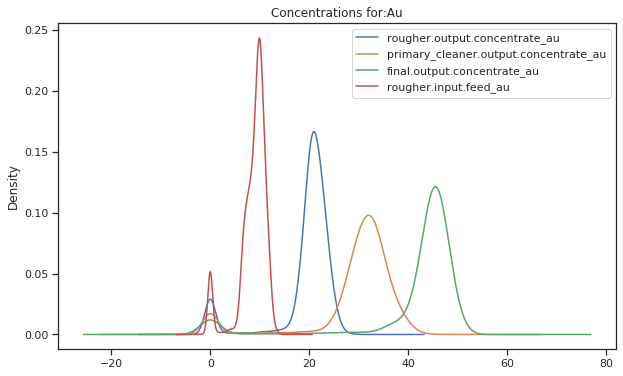

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au,rougher.input.feed_au
count,5856.000000,5856.000000,5856.000000,5856.000000
mean,19.253342,29.345056,41.533053,8.702056
std,6.198590,9.146974,11.642682,2.805083
min,0.000000,0.000000,0.000000,0.000000
25%,19.455514,28.820022,43.188581,7.765897
50%,20.833886,31.594158,45.091467,9.455566
75%,22.338619,33.944933,46.443150,10.383540
max,28.824507,44.550325,51.233068,13.731330


****************************************************************************************************

CONCENTRATION OF:  Ag


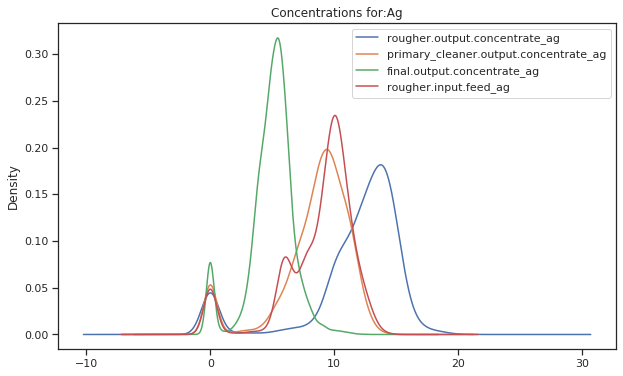

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.input.feed_ag
count,5856.000000,5856.000000,5856.000000,5856.000000
mean,11.719931,8.462717,4.966519,8.736408
std,4.043892,2.989888,1.813711,2.986819
min,0.000000,0.000000,0.000000,0.000000
25%,10.808314,7.471621,4.219248,7.601568
50%,12.802395,9.100659,5.186198,9.632789
75%,14.160276,10.370482,5.967188,10.565152
max,20.483505,14.159305,12.285296,14.406130


****************************************************************************************************

CONCENTRATION OF:  Pb


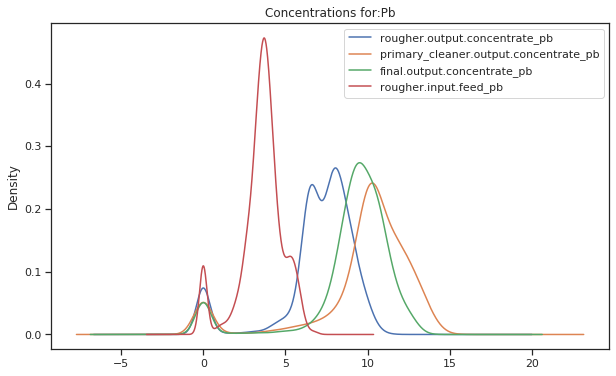

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,rougher.input.feed_pb
count,5856.000000,5856.000000,5856.000000,5856.000000
mean,6.960632,9.717700,9.044673,3.553991
std,2.423921,3.291939,2.723200,1.326899
min,0.000000,0.000000,0.000000,0.000000
25%,6.414649,9.375618,8.636027,3.081297
50%,7.532974,10.361712,9.542149,3.682847
75%,8.404772,11.621722,10.512381,4.247571
max,13.325742,15.426466,13.744729,6.905684


****************************************************************************************************

CONCENTRATION OF:  SOL


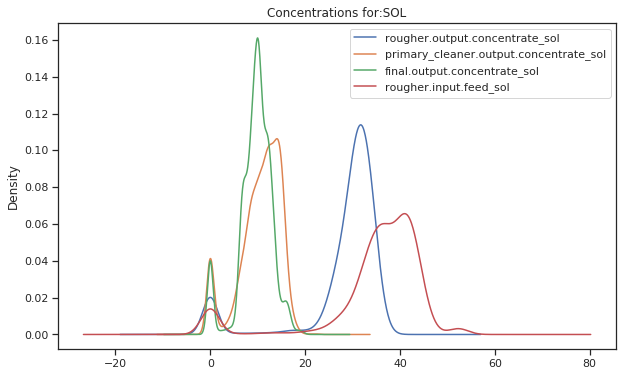

,rougher.output.concentrate_sol,primary_cleaner.output.concentrate_sol,final.output.concentrate_sol,rougher.input.feed_sol
count,5856.000000,5856.000000,5856.000000,5856.000000
mean,28.066229,10.566550,9.606495,34.933424
std,9.141012,4.358486,3.498563,10.982995
min,0.000000,0.000000,0.000000,0.000000
25%,28.105987,8.469791,8.027986,33.237351
50%,30.864162,11.435272,9.965407,37.291247
75%,32.825174,13.892878,11.828903,41.366656
max,38.015450,22.458114,19.615720,53.477742


****************************************************************************************************



In [13]:
PRINT_SEPARATOR()
print('TRAINING SAMPLE: TOTAL CONCENTRATION OF ALL SUBSTANCES AT VARIOUS STAGES')
concentrationMetals('Au',ALL_AU_LIST,df_train)
concentrationMetals('Ag',ALL_AG_LIST,df_train)
concentrationMetals('Pb',ALL_PB_LIST,df_train)
concentrationMetals('SOL',ALL_SOL_LIST,df_train)
PRINT_SEPARATOR()
print('TEST SAMPLE: TOTAL CONCENTRATION OF ALL SUBSTANCES AT VARIOUS STAGES')
concentrationMetals('Au',ALL_AU_LIST,df_test)
concentrationMetals('Ag',ALL_AG_LIST,df_test)
concentrationMetals('Pb',ALL_PB_LIST,df_test)
concentrationMetals('SOL',ALL_SOL_LIST,df_test)
PRINT_SEPARATOR()

# CONCLUSION
- There are lots of 'zero' or 'near zero' values in all 4 metals in various stages.
- We need to identify them and remove these records as outliers.


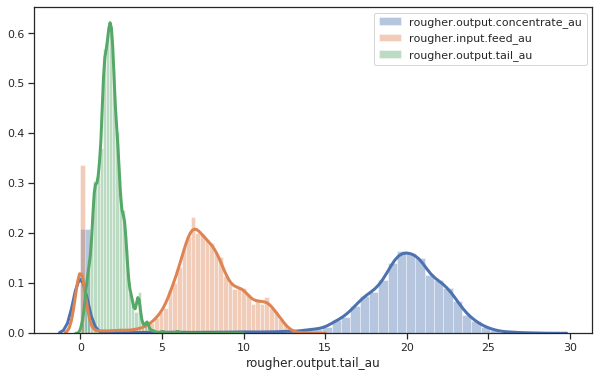

****************************************************************************************************



'df_train, Concentrate, Feed, Tail - all three zero'

16860

1213

0.07194543297746145

'df_test, Concentrate, Feed, Tail - all three zero'

5856

371

0.06335382513661202

13488    0.01
16192    0.01
16193    0.01
16194    0.01
16195    0.01
Name: rougher.input.feed_au, dtype: float64

2050     0.0
2045     0.0
2046     0.0
11430    0.0
11429    0.0
Name: rougher.output.concentrate_au, dtype: float64

16788    0.020676
15848    0.024545
16789    0.031234
13093    0.031642
12614    0.049731
Name: rougher.output.tail_au, dtype: float64

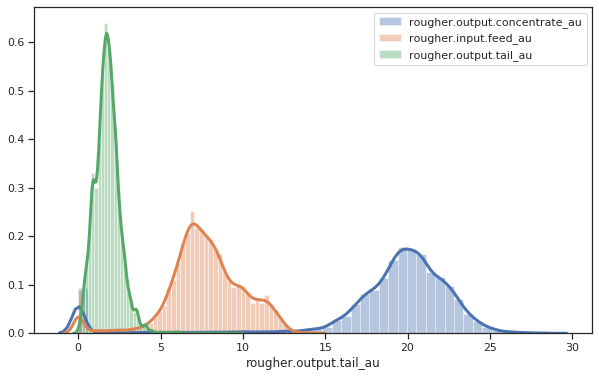

In [14]:
#Check Outliers for RECOVERY FORMULA
def  removeRecoveryOutliers(CCol,FCol,TCol):

      C=df_train[CCol] 
      F = df_train[FCol]
      T=df_train[TCol]

      DRAW_DISTPLOT([C,F,T],[CCol,FCol,TCol],True)

      PRINT_SEPARATOR()
      #Identify Outliers
      tmp = df_train[((df_train[CCol]<=0.0) & (df_train[TCol]<=0.0) & (df_train[FCol]<=0.0 )) | ((df_train[CCol]<=0.0) &  (df_train[FCol]<=0.0))| (df_train[FCol]<=0.0)]
      DISPLAY(tmp[[CCol,FCol,TCol]].sort_values(by=CCol).tail(5))
      display('df_train, Concentrate, Feed, Tail - all three zero',len(df_train),len(tmp),len(tmp)/len(df_train))

      tmp1 = df_test[((df_test[CCol]<=0.0) & (df_test[TCol]<=0.0) & (df_test[FCol]<=0.0 )) | ((df_test[CCol]<=0.0) &  (df_test[FCol]<=0.0 ))| (df_test[FCol]<=0.0)]
      DISPLAY(tmp1[[CCol,FCol,TCol]].sort_values(by=CCol).tail(5))
      display('df_test, Concentrate, Feed, Tail - all three zero',len(df_test),len(tmp1),len(tmp1)/len(df_test))

      #Remove outliers TRAINING DATA
      PRINT(tmp.index)
      df_train.drop(tmp.index,inplace=True)
      PRINT(len(df_train))

      #Remove outliers TEST DATA
      PRINT(tmp1.index)
      df_test.drop(tmp1.index,inplace=True)
      PRINT(len(df_test))

      C=df_train[CCol] 
      F = df_train[FCol]
      T=df_train[TCol]

      display(F.sort_values().head(5),C.sort_values().head(5),T.sort_values().head(5))

      DRAW_DISTPLOT([C,F,T],[CCol,FCol,TCol],True)

removeRecoveryOutliers('rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au')
PRINT(df_train.shape,df_all[0].shape,df_test.shape,df_all[1].shape)

# CONCLUSION 
- Removed outliers based on the values used in Recovery Formula for Au.
- The hump near zero is reduced.
- All zero value rows for roughter.input.feed_au were removed
- Will further process the outliers based on IQR below.

# REMOVE OUTLIERS BASED ON LOWER RANGE - 0.025% of IQR 

****************************************************************************************************

df_train
****************************************************************************************************

CONCENTRATION OF:  All Metals before removal of outliers: df_train


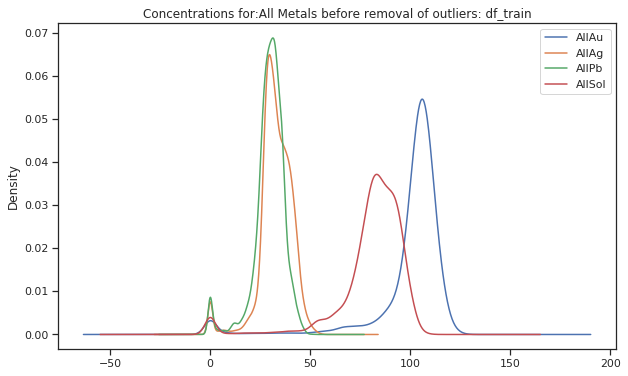

,AllAu,AllAg,AllPb,AllSol
count,15647.000000,15647.000000,15647.000000,15647.000000
mean,99.617542,32.690414,29.655686,80.267898
std,20.668182,8.353818,7.684828,18.277003
min,0.040000,0.040000,0.000000,0.000000
25%,99.462553,28.748538,26.660267,76.516229
50%,104.778830,32.685997,30.499147,83.742635
75%,108.926690,38.183440,34.246536,90.989833
max,126.765553,55.959480,51.311488,109.988058


TOTAL OUTLIERS 1507 10.657708628005658 % old Length 15647 new Length 14140
****************************************************************************************************

CONCENTRATION OF:  All Metals after removal of outliers: df_train


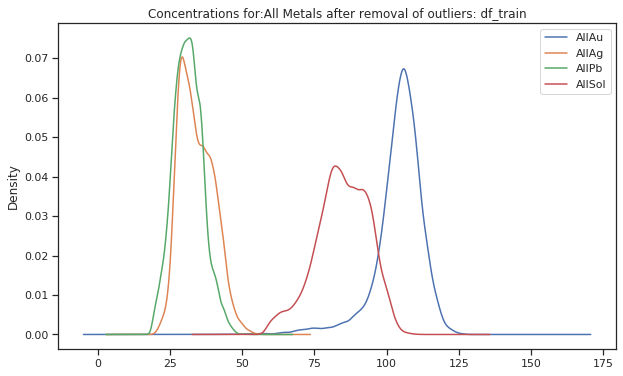

,AllAu,AllAg,AllPb,AllSol
count,14140.000000,14140.000000,14140.000000,14140.000000
mean,104.322308,34.202542,31.301094,84.631835
std,8.409908,5.864224,5.065177,9.097962
min,38.968936,20.591841,18.942292,58.441930
25%,101.114828,29.471988,27.704792,78.869834
50%,105.468602,33.359276,31.159760,84.891739
75%,109.295662,38.592288,34.720086,91.606536
max,126.765553,55.959480,51.311488,109.988058


****************************************************************************************************

df_test
****************************************************************************************************

CONCENTRATION OF:  All Metals before removal of outliers: df_test


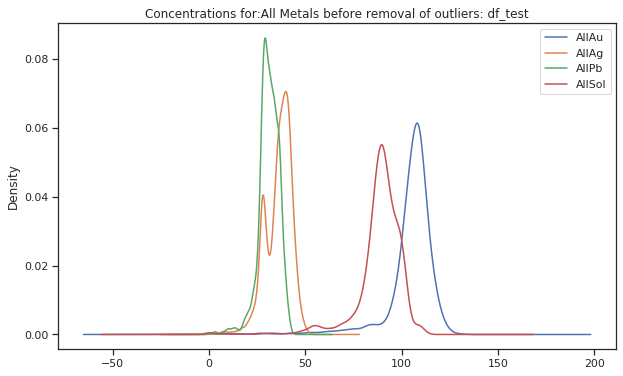

,AllAu,AllAg,AllPb,AllSol
count,5485.000000,5485.000000,5485.000000,5485.000000
mean,104.633512,35.997186,30.998666,88.548215
std,12.976520,6.741471,5.300683,12.142315
min,0.568632,0.568441,0.273677,0.000000
25%,102.368431,31.640269,28.251594,85.495959
50%,107.101886,37.260343,31.200758,90.026634
75%,110.778824,40.792309,34.630911,95.312935
max,132.272157,52.189114,42.726320,112.357196


TOTAL OUTLIERS 531 10.718611223253935 % old Length 5485 new Length 4954
****************************************************************************************************

CONCENTRATION OF:  All Metals after removal of outliers: df_test


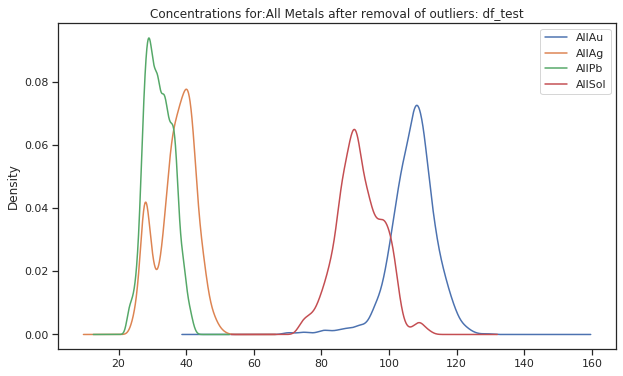

,AllAu,AllAg,AllPb,AllSol
count,4954.000000,4954.000000,4954.000000,4954.000000
mean,106.912363,37.055711,31.961170,91.253820
std,6.888216,5.570665,3.967603,6.758906
min,68.963865,23.814398,22.605219,73.026676
25%,103.445791,33.682235,28.835132,86.754382
50%,107.499910,37.895973,31.671882,90.755396
75%,110.932666,41.113666,35.012406,96.044022
max,129.403302,52.189114,42.726320,112.357196


In [15]:
#Get IQR for each concentrate in the dataset
i=0
def process_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    whisker_high = q3+1.5*iqr
    whisker_low  = df_in[col_name].quantile(0.025)
  
    df_outliers = df_in[df_in[col_name] < whisker_low]
    df_out = df_in[df_in[col_name] >= whisker_low]
    DISPLAY(df_outliers[col_name])
    PRINT(col_name, ':', len(df_outliers))
    return (len(df_outliers),df_out)

for df in df_all:
    dfName = df_all_names[i]
    PRINT_SEPARATOR()
    print(dfName)
    
    df['AllAu'] = df[ALL_AU_LIST].sum(axis=1)
    df['AllAg'] = df[ALL_AG_LIST].sum(axis=1)
    df['AllPb'] = df[ALL_PB_LIST].sum(axis=1)
    df['AllSol'] = df[ALL_SOL_LIST].sum(axis=1)

    concentrationMetals('All Metals before removal of outliers: '+dfName,listAllMetals,df)

    totOutliers=0
    len_train = len(df)
    for col in listAllMetals:
      numOutliers,df= process_outlier(df,col)
      totOutliers += numOutliers
    newlen_train = len(df)
    print("TOTAL OUTLIERS",totOutliers,totOutliers*100/len(df),'%','old Length',len_train,'new Length', newlen_train)
    concentrationMetals('All Metals after removal of outliers: '+dfName,listAllMetals,df)
    df.drop(listAllMetals,axis=1,inplace=True)
    df_all[i] = df  #just in case reference doesn't change
    i=i+1

df_train=df_all[0]
df_test=df_all[1]
PRINT(df_train.shape,df_all[0].shape,df_test.shape,df_all[1].shape)

## 2.3 CONCLUSION - PROCESS OUTLIERS
- There are a few outliers in all three groups which were lower than the quantile(0.025) in values.
- Both Train and Test datasets were processed for outliers.
- There are approximately 10% of the outliers that were removed from Training and Test datasets.
- Removal of outliers resulted in removal of the hump in the charts "near the zero values" for all metals.

# EXPLORATORY DATA ANALYSIS
- Heatmap
- Bar Chart

Heatmap for: df_train


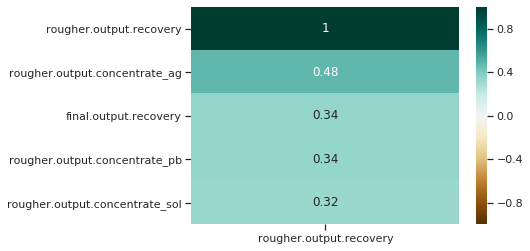

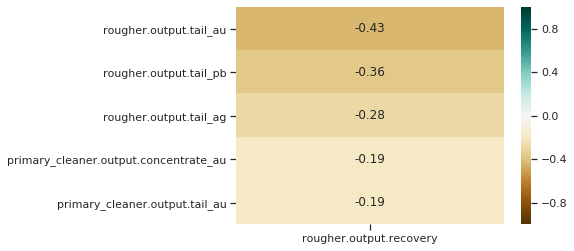

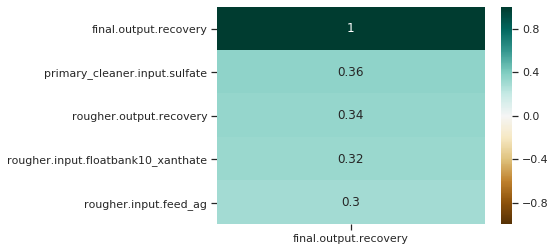

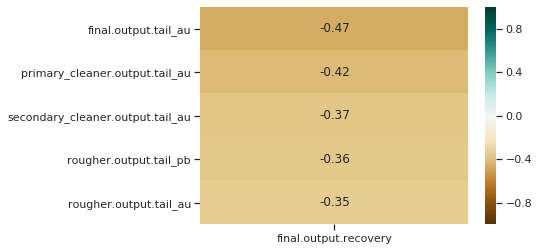

In [16]:
  i=0 #df_train
  df = df_all[i]
  print("Heatmap for:", df_all_names[i])
  heatmap = display(sns.heatmap(df.corr()[[TARGET1]].sort_values(by=TARGET1, ascending=False).head(5), vmin=-1, vmax=1, annot=True, cmap='BrBG'))
  plt.show()
  heatmap = display(sns.heatmap(df.corr()[[TARGET1]].sort_values(by=TARGET1).head(5), vmin=-1, vmax=1, annot=True, cmap='BrBG'))
  plt.show()
  heatmap = display(sns.heatmap(df.corr()[[TARGET2]].sort_values(by=TARGET2, ascending=False).head(5), vmin=-1, vmax=1, annot=True, cmap='BrBG'))
  plt.show()
  heatmap = display(sns.heatmap(df.corr()[[TARGET2]].sort_values(by=TARGET2).head(5), vmin=-1, vmax=1, annot=True, cmap='BrBG'))
  plt.show()

# CONCLUSION
- The heatmap depicts that rougher.output.recovery has strong positive correlation with rougher.output.concentrate_ag,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.concentrate_pb.

- It has negative correlation with rougher.output.tail_au,rougher.output.tail_pb, rougher.output.tail_ag.
- final.output.recovery is positively related with date, rougher.output.recovery, input.feed_ag.
- final.output.recovery is negatively related with output.tail of au, pb and cleaner.

Bargraph for: df_train


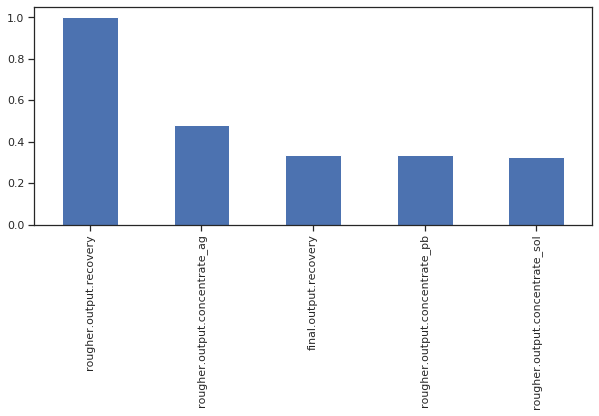

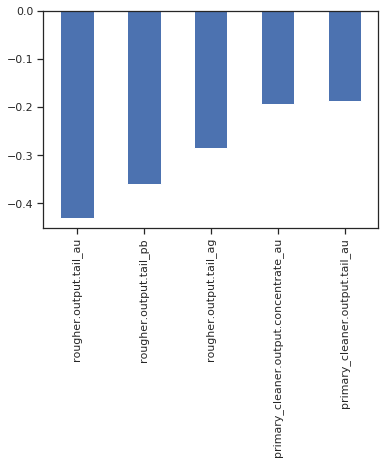

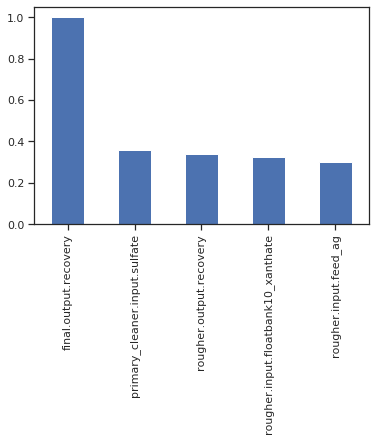

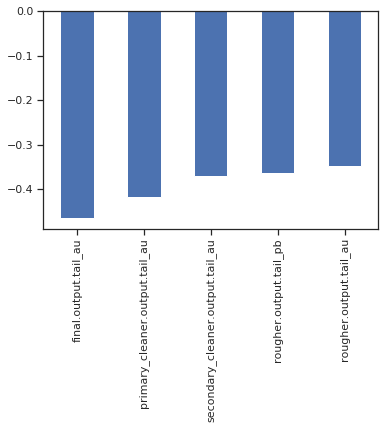

In [17]:
  print("Bargraph for:", df_all_names[i])
  plt.figure(figsize=(10,4))
  df.corr()[TARGET1].sort_values(ascending = False).head(5).plot(kind='bar')
  plt.show()
  df.corr()[TARGET1].sort_values().head(5).plot(kind='bar')
  plt.show()
  df.corr()[TARGET2].sort_values(ascending = False).head(5).plot(kind='bar')
  plt.show()
  df.corr()[TARGET2].sort_values().head(5).plot(kind='bar')
  plt.show()

# CONCLUSION

- The barchart also depicts that rougher.output.recovery has strong positive correlation with rougher.output.concentrate_ag,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.concentrate_pb.

- It has negative correlation with rougher.output.tail_au,rougher.output.tail_pb, rougher.output.tail_ag.

- final.output.recovery has positive correlation with the cleaner (sulfate), rougher.output.recovery and float - xanthalate.
- final.output.recovery has negative correlation with primary_cleaner.tail_au, secondary_cleaner.output.tail_au , and rougher.output tails of pb, au.

# 1.2 RECOVERY FORMULA

In [18]:
def calculateRecovery(CCol,FCol,TCol,RCol,NewCol):
      C=df_train[CCol]
      F = df_train[FCol]
      T=df_train[TCol]
      R=df_train[RCol]

      FT = F-T
      CT = C-T
      PRINT_SEPARATOR()

      display('F-T head and tail')
      display(FT.sort_values().head(5),FT.sort_values().tail(5))
      PRINT_SEPARATOR()
      display('C-T head and tail')
      display(CT.sort_values().head(5),CT.sort_values().tail(5))
      PRINT_SEPARATOR()

      #All feedValues=0 were removed earlier, so we don't need to use EPSILON in DENOMINATOR for Division.
      #RECOVERY = ((C * (F-T) ) / ((F * (C-T)) + EPSILON)) * 100
      RECOVERY = (C * (F-T) ) / (F * (C-T)) * 100
     
      RECOVERY = np.where(RECOVERY > 100, 100,RECOVERY)
      RECOVERY = np.where(RECOVERY < 0, 0,RECOVERY)
      df_train[NewCol] = RECOVERY

      DISPLAY(df_train[NewCol].head(5))
      DISPLAY(df_train[RCol].head(5))

      DISPLAY(df_train[NewCol].sort_values(ascending=False).tail(5))
      DISPLAY(df_train[RCol].sort_values(ascending=False).tail(5))
      tmp= df_train[NewCol] - df_train[RCol]
      
      #display(tmp.head(5))
      DRAW_DISTPLOT([R,RECOVERY,tmp],['Recovery', 'Calc Recovery', 'Difference'],True)
      
      mae_rougher = mean_absolute_error(df_train[RCol],df_train[NewCol])
      print('Recovery MAE',mae_rougher)
      df_train.drop([NewCol], axis=1,inplace=True)  #drop the extra column that was added

****************************************************************************************************

ROUGHER OUTPUT RECOVERY
****************************************************************************************************



'F-T head and tail'

2491   -0.779612
8627   -0.287160
8945   -0.096808
4615    0.081085
1200    0.081754
dtype: float64

13816    11.336755
15524    11.406383
15512    11.489694
13800    11.527387
15529    11.575835
dtype: float64

****************************************************************************************************



'C-T head and tail'

2073   -2.945371
2391   -2.619551
4791   -2.587677
2074   -2.538689
2392   -2.409091
dtype: float64

3459    24.766039
4162    24.806003
3479    24.996530
3458    25.114919
3476    25.268306
dtype: float64

****************************************************************************************************



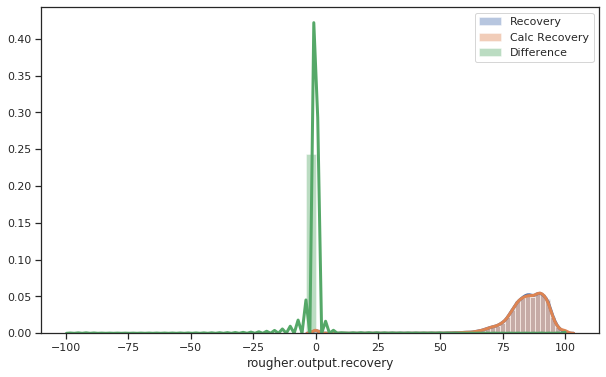

Recovery MAE 0.6242009318823277


In [19]:
PRINT_SEPARATOR()
print('ROUGHER OUTPUT RECOVERY')
calculateRecovery('rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au','rougher.output.recovery','ROUGHER_RECOVERY')

# CONCLUSION 1.2
- The Recovery value on the 'rougher.output.recovery' has an MAE of 0.624 with 
the Recovery calculated using (C * (F-T)) / (F * (C-T))
- This MAE exists because we have float values and division in the RECOVERY FORMULA causes truncation.

# 2.1  CONCENTRATION OF METALS (Au, Ag, Pb)
**Take Note of how the concentrations of metals (Au, Ag, Pb) change depending on the Purification Stage**

****************************************************************************************************

CONCENTRATION OF:  Au


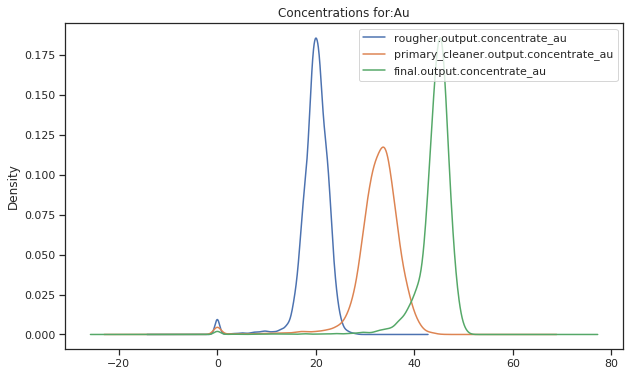

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,14140.000000,14140.000000,14140.000000
mean,19.699982,32.527867,44.045089
std,3.310684,5.160091,4.460294
min,0.000000,0.000000,0.000000
25%,18.583622,30.796759,43.226830
50%,20.053952,33.134639,44.834521
75%,21.505523,35.248131,46.122671
max,28.522811,45.933934,51.489612


****************************************************************************************************

CONCENTRATION OF:  Ag


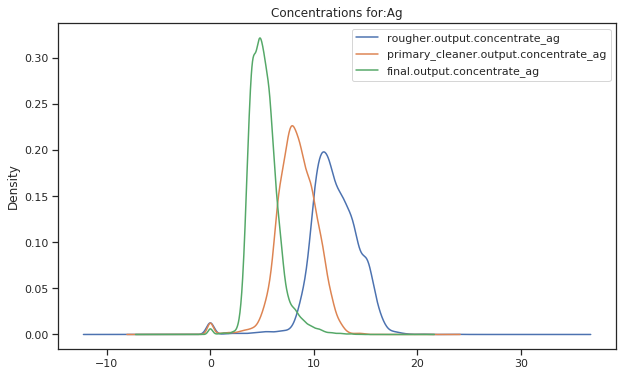

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,14140.000000,14140.000000,14140.000000
mean,11.919735,8.339689,5.213268
std,2.467541,1.917379,1.414378
min,0.000000,0.000000,0.000000
25%,10.568275,7.195724,4.240971
50%,11.839273,8.320055,5.029264
75%,13.498194,9.622168,5.908853
max,24.480271,16.081632,14.419224


****************************************************************************************************

CONCENTRATION OF:  Pb


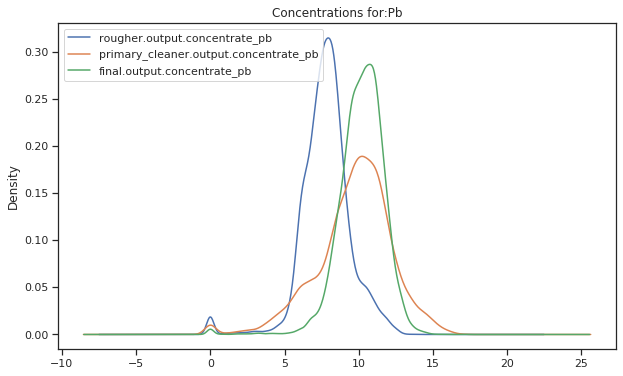

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,14140.000000,14140.000000,14140.000000
mean,7.800710,9.689434,10.209983
std,1.675945,2.556354,1.519482
min,0.000000,0.000000,0.000000
25%,6.945406,8.409460,9.365715
50%,7.823777,9.972849,10.318397
75%,8.656103,11.323105,11.183947
max,14.983547,17.081278,17.031899


In [20]:
PRINT(df_train.shape,df_all[0].shape,df_test.shape,df_all[1].shape)
concentrationMetals('Au',CONCENTRATE_AU_LIST,df_train)
concentrationMetals('Ag',CONCENTRATE_AG_LIST,df_train)
concentrationMetals('Pb',CONCENTRATE_PB_LIST,df_train)

rougher.output.concentrate_au            19.699982
rougher.output.concentrate_ag            11.919735
rougher.output.concentrate_pb             7.800710
primary_cleaner.output.concentrate_au    32.527867
primary_cleaner.output.concentrate_ag     8.339689
primary_cleaner.output.concentrate_pb     9.689434
final.output.concentrate_au              44.045089
final.output.concentrate_ag               5.213268
final.output.concentrate_pb              10.209983
dtype: float64

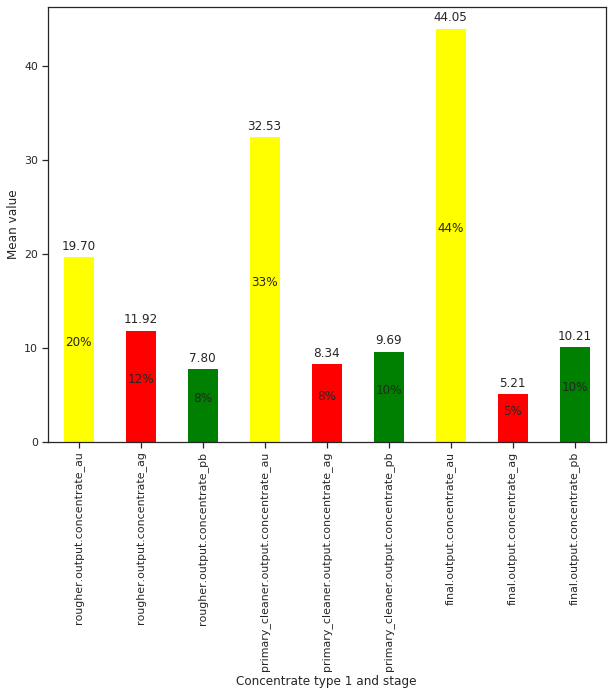

In [21]:
tmp = df_train[CONCENTRATE_LIST].mean()
display(tmp)
ax = tmp.plot.bar(figsize=(10,8),color=['yellow', 'red', 'green'])
ax.set(xlabel='Concentrate type 1 and stage',ylabel='Mean value')
for rec in ax.patches:
    ax.annotate("%.2f" % rec.get_height(), (rec.get_x() + rec.get_width() / 2., rec.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
    height = rec.get_height()
    ax.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

# 2.1 CONCLUSION
The above charts (distribution plots) and the barchart display that:
1. Concentration of Au increased from Rougher to Primary Cleaner to Final Output. (20% to 33% to 44%)
2. Concentration of Ag Reduced from Rougher to Primary Cleaner to Final. (12% to 8% to 5%)
3. Concentration of Lead increased from Rougher to Primary Cleaner to Final. (8% to 10% to 10%)

# 2.2 COMPARE THE FEED PARTICLE SIZE DISTRIBUTIONS
** Compare distribution in the training set and the test set.

** If the distribution varies significantly, the model evaluation will be incorrect


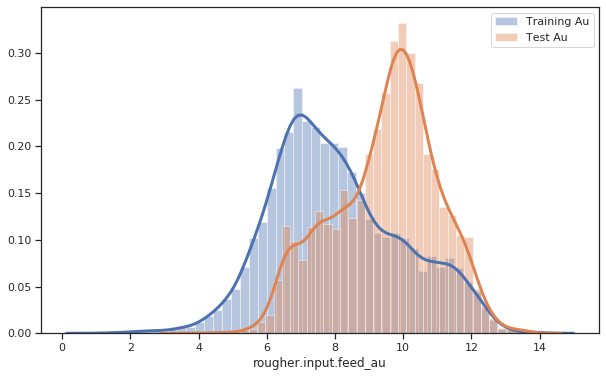

count    14140.000000
mean         8.049369
std          1.920532
min          1.031063
25%          6.697059
50%          7.786654
75%          9.308836
max         14.093363
Name: rougher.input.feed_au, dtype: float64

count    4954.000000
mean        9.468383
std         1.523785
min         3.771721
25%         8.403896
50%         9.685945
75%        10.507913
max        13.731330
Name: rougher.input.feed_au, dtype: float64

In [22]:
PRINT(df_train.shape,df_all[0].shape,df_test.shape,df_all[1].shape)
train_au = df_train['rougher.input.feed_au']
test_au = df_test['rougher.input.feed_au']
DRAW_DISTPLOT([train_au,test_au],['Training Au','Test Au'],True)
display( train_au.describe(), test_au.describe())

# 2.2 CONCLUSION
- The distribution of input feed is similar in training and test dataset.
- The Standard Deviation is 1.9 in Training dataset and 1.5 in Test dataset.
- The Mean, Min, Max are very close in the Test and Train dataset. The Min is a bit higher in the Test Dataset. That may be because it has a limited set of values and training set is much bigger.

# STEP-3: BUILD THE MODEL

# 3.2 Train and test different models:
- 2.1. Identify Feature and Target in Train and Test sets
- 2.2. Scale the Features in Train and Test datasets.
- 2.2. Apply different regression methods to identify the best model for the two Targets - 
 -  rougher.output.recovery
 -  final.output.recovery.

In [23]:
PRINT(df_train.shape,df_all[0].shape,df_test.shape,df_all[1].shape)
df=df_all[0]
df_test = df_all[1]

PRINT(np.isnan(df).any())
PRINT(np.isnan(df_test).any())

features =  df.drop(TARGETS , axis=1)
target = df[TARGETS]

features_test =  df_test.drop(TARGETS , axis=1)
target_test_rougher = df_test[TARGETS[0]]
target_test_final = df_test[TARGETS[1]]
target_tests = [target_test_rougher,target_test_final]

#Standardize the numerical features, all features are numeric
scaler = StandardScaler()

# < transform feature set >
features = pd.DataFrame(scaler.fit_transform(features),columns = features.columns)
features_test = pd.DataFrame(scaler.fit_transform(features_test),columns = features_test.columns)


#SPLIT TRAINING INTO TRAINING (75%) AND VALIDATION_TEST (25%)
features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE)

totsize = len(df)
PRINT_SEPARATOR()
print('training set  : {0:.0%}'.format(len(features_train) /totsize),features_train.shape, ', training target   :',target_train.shape)
print('validation set: {0:.0%}'.format(len(features_valid)/totsize),features_valid.shape,', validation target :',target_valid.shape)

target_train_rougher = target_train[TARGETS[0]]
target_train_final = target_train[TARGETS[1]]
target_trains = [target_train_rougher,target_train_final]

target_valid_rougher = target_valid[TARGETS[0]]
target_valid_final = target_valid[TARGETS[1]]
target_valids = [target_valid_rougher,target_valid_final]


****************************************************************************************************

training set  : 75% (10605, 85) , training target   : (10605, 2)
validation set: 25% (3535, 85) , validation target : (3535, 2)


# 3.1 WRITE A FUNCTION TO CALCULATE THE FINAL sMAPE value

In [24]:
#SMAPE. The SMAPE (Symmetric Mean Absolute Percentage Error) is a variation on the MAPE that is calculated 
#using the average of the absolute value of the actual and the absolute value of the forecast in the denominator.
#This statistic is preferred to the MAPE by some and was used as an accuracy measure in several forecasting competitions.

def smape_scorer(target: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(2.0 * np.abs(target - predicted) / ((np.abs(target) + np.abs(predicted)) + EPSILON))

#map smape_scoring - to be used in model scoring for GridSearchCV.    
smape_scoring = {'SMAPE': make_scorer(smape_scorer)}

# 3.1 CONCLUSION
- function smape_scorer was defined and written
- make_scorer was used to wrap this scoring function wrapsuse in GridSearchCV and cross_val_score.
- Metric string 'SMAPE' was defined for smape_scorer
- This scoring function will be used in model evaluation in 3.2.

# 3.2b EVALUATE DIFFERENT MODELS (TWO TARGETS)
- Train on training dataset
- Evaluate using validation dataset
- Test results on test dataset
- Report the final models for the two targets

In [28]:
"""
The best models are:
    1. Random Forest Regressor
    2. Linear Regression
    3. Ridge Regression
    4. Lasso Regression (L1 Regularization)
    5. Elastic-Net Regression
    
    GridSearchCV
    https://mlfromscratch.com/gridsearch-keras-sklearn/
"""
def choose_best_model(feature_train, target_train,feature_valid,target_valid):
    models = list()
    models.append(get_LinearRegression())
    models.append(get_RidgeRegression())
    models.append(get_LassoRegression())
    models.append(get_ElasticNetRegression())
    models.append(get_RandomForestRegression())

    for model in models:
        train_model(model, feature_train, target_train)
    
    best_models = []
    for model in models:
        best_models.append(get_best_model(model))
    return min(best_models, key=lambda model:smape_scorer(target_valid,model.predict(feature_valid)))

def get_LinearRegression():
    print('Linear Regression..')
    linear = LinearRegression()
    linear_params = {
              "fit_intercept": [True, False],
              "normalize": [True, False],
             }
    grid_result = GridSearchCV(linear, linear_params,scoring=smape_scoring,refit='SMAPE',n_jobs=-1)
    return grid_result

def get_RidgeRegression():
    print('Ridge Regression (Linear)')
    ridge = Ridge(random_state=RANDOM_STATE)
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    ridge_params = dict(alpha=alpha)
    grid_result = GridSearchCV(ridge, ridge_params,scoring=smape_scoring,refit='SMAPE',n_jobs=-1)
    return grid_result

def get_LassoRegression():
    print('Lasso Regression (Linear)')
    lasso = Lasso(random_state=RANDOM_STATE)
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    lasso_params = dict(alpha=alpha)
    grid_result = GridSearchCV(lasso, lasso_params,scoring=smape_scoring,refit='SMAPE',n_jobs=-1)
    return grid_result

def get_ElasticNetRegression():
    print('ElasticNet Regression (Linear)')
    elasticNet = ElasticNet(random_state=RANDOM_STATE)
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    elastic_params = dict(alpha=alpha, l1_ratio=l1_ratio)
    grid_result = GridSearchCV(elasticNet,elastic_params,scoring=smape_scoring,refit='SMAPE',n_jobs=-1)
    return grid_result

def get_RandomForestRegression():
    print('RandomForest Regression')
    random_forest = RandomForestRegressor(random_state=RANDOM_STATE)
    random_params = {'n_estimators':range(10,50,100),'max_depth': range(2,7)}
    grid_result = GridSearchCV(random_forest, random_params,scoring=smape_scoring,refit='SMAPE',n_jobs=-1)
    return grid_result

def train_model(model, feature_train, target_train):
    model.fit(feature_train, target_train)
    
    PRINT_SEPARATOR()
    print('Model Name: ',model.best_estimator_)
    print('Best Score: ', model.best_score_)
    print('Best Params: ', model.best_params_)
    
def get_best_model(model):
    if not hasattr(model, 'best_estimator_'):
        return model
    return model.best_estimator_

In [29]:
PRINT_SEPARATOR()
print('Evaluating Models for,',TARGETS[0])
best_model_rougher = choose_best_model(features_train, target_train_rougher,features_valid,target_valid_rougher)
PRINT_SEPARATOR()
print('Evaluating Models for:',TARGETS[1])
best_model_final = choose_best_model(features_train, target_train_final,features_valid,target_valid_final)

****************************************************************************************************

Evaluating Models for, rougher.output.recovery
Linear Regression..
Ridge Regression (Linear)
Lasso Regression (Linear)
ElasticNet Regression (Linear)
RandomForest Regression
****************************************************************************************************

Model Name:  LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
Best Score:  1.8020334818957833
Best Params:  {'fit_intercept': False, 'normalize': True}
****************************************************************************************************

Model Name:  Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=12345, solver='auto', tol=0.001)
Best Score:  0.059158860869270226
Best Params:  {'alpha': 1000}
****************************************************************************************************

Model Name:  Lasso(alph

# CONCLUSION 
- Various regression models were trained on training set and evaluated on validation datasets.
- GridSearchCV was used to find the best parameters and cross-validation.
- Results of SMAPE for each model was calculated.
- Based on the evaluation, Ridge Regression comes to be the best model for both targets.

<div class="alert alert-block alert-success">
<b>Success:</b> Great that you've tried a lot of models!
</div>

# FINALIZED BEST MODELS and OVERALL SMAPE

In [30]:
PRINT_SEPARATOR()
print('BEST Model for ', TARGETS[0])
print('Model name:',best_model_rougher)
predicted_test_rougher = best_model_rougher.predict(features_test)
smape_score_rougher = smape_scorer(target_tests[0],predicted_test_rougher)*100
print('SMAPE %age:', smape_score_rougher)
PRINT_SEPARATOR()

print('BEST Model for ', TARGETS[1])
print('Model name:',best_model_final)
predicted_test_final = best_model_final.predict(features_test)
smape_score_final  = smape_scorer(target_tests[1],predicted_test_final)*100
print('SMAPE %age:', smape_score_final)
PRINT_SEPARATOR()

totalSMAPE = .25 * smape_score_rougher + .75 * smape_score_final
print('Overall SMAPE Score for both models:',totalSMAPE)

****************************************************************************************************

BEST Model for  rougher.output.recovery
Model name: Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=12345, solver='auto', tol=0.001)
SMAPE %age: 7.868611955561937
****************************************************************************************************

BEST Model for  final.output.recovery
Model name: Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=12345, solver='auto', tol=0.001)
SMAPE %age: 10.054318312668453
****************************************************************************************************

Overall SMAPE Score for both models: 9.507891723391824


# 3.2 CONCLUSION
- Ridge Regression was the Best Model for both targets - 
 
 - rougher.output.recovery and final.output.recovery
 - Overall SMAPE score is 9.50%
 

<div class="alert alert-block alert-success">
<b>Success:</b> Testing part was done perfectly!
</div>

# Project evaluation

X- Evaluation criteria for the project.

X- Here’s what the reviewers will look at when reviewing your project:

X- Have you prepared and analyzed the data properly?

X- What models have you developed?

X- How did you check the model's quality?

X- Have you followed all the steps of the instructions?

X- Did you keep to the projext structure and explain the steps performed?


# Thank you for evaluating my project.